## GeometricErrors - Point Shifting 

For KDD 2021

### Part 1: Loading Data

In [ ]:
""" Environment Configuration """

# Source of input tensors. 
data_path = '/data/GeometricErrors/EM'

# Source of original rasters, shapefiles.
source_path ='/data/GeometricErrors/Scene01'

# Label of dataset used (Original = 1, New = 2)
dataset_label = 1

# Path to save EM Test as folder
out_root_dir = '/data/GeometricErrors/tests'

# Enables training with GPU
use_gpu = True
gpus = ['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3']

# Environment Seeds
tf_seed = 2001 # Tensorflow
np_seed = 2001 # Numpy
py_seed = 2001 # Python

# Pre-Load Determiner.
preload = False
#   ^^^
# - True, the candidates are loaded and stored. 
# - False, the candidates are loaded from jupyter persistent storage




# Weights to load when skipping training
std_weight_path = '/data/GeometricErrors/tests/BaselineWeights.h5'


""" Point Shifting Annotator Configuration """

# number of points to generate on BOTH sides of each source point
pairs = 15

# Interval at which shifting vertices are sampled in meters
interval = 10

# Offset distance between coordinate points as they are generated on either side of the source. (meters)
off_dist = 1.5

# Minimum Valid Proability over map
min_probability = 1e-06

# Weight consideration candidate0 line distance between candidate points
length_weight_value = 0

# Buffer in meters to apply to candidates
weight_buffer = 2

buff_dist = 4
# Option to normalize over K^2 (True) or by K (False).
normalize_full = False


""" UNET Config """

# Base learning rate to use in training. Reccomend 0.01
learning_rate = 0.1




""" EM Iteration Config """

# Initial jump-start predicted class map path
seg_class_map_fp = '/data/pmap.tif'

# Number of EM iterations
em_target = 6


# Learning Rate Scheduler
import lib.K_Tools as kt 
lr_schedule = kt.Oscillate_LR

# Optionally Enable notes
prompt_notes = False


In [ ]:
# Std Imports
import os, sys, time, random, csv
from datetime import datetime as dt 

# Module Imports
import tensorflow as tf
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as shp
from tensorflow.keras.optimizers import Adam

# Lib imports
import lib.Doc_Tools as doc
import lib.GeoTools as gt
import lib.Tiling as tile
import lib.K_Tools as kt
from lib.Annotators import *

""" Static Configuration """
# Batch size for training
batch_size = 32
# Early Stopping Patience
es_patience = 20
# Reduce Learning Rate on Plateau: Multiplier to reduce LR by upon plateau
rlop_factor = 0.5
# Adam Optimizer config
adam_epsilon = 1e-8
adam_decay = 1e-5
# Buffer in meters applied to annotations when comparing iou
iou_buffer = 6

# Seed environment
random.seed(py_seed)
tf.random.set_seed(tf_seed)
np.random.seed(np_seed)

# Prompt for notes on test
if prompt_notes:
    test_notes = input("Enter Notes for test: ")
else:
    test_notes = 'Notes have been disabled.'
    
### Create Folder for test documentation
test_idx, test_dir = doc.InitTest(out_root_dir,
                                  em_target=em_target,
                                  LR=learning_rate,
                                  notes=test_notes,
                                  pairs=pairs,
                                  interval=interval,
                                  off_distance=off_dist,
                                  min_p=min_probability,
                                  L=length_weight_value)

### Loading Source
train_raster = rio.open('{}/train_raster.tif'.format(source_path))
test_raster = rio.open('{}/test_raster.tif'.format(source_path))
template_raster = rio.open('{}/template_map.tif'.format(source_path))

gt_labels = gpd.read_file('{}/GroundTruth.shp'.format(source_path))
imp_labels = gpd.read_file('{}/imperfectLines.shp'.format(source_path))

### Loading Tensors
X_train = np.load('{}/X_train.npy'.format(data_path))
Y_train = np.load('{}/Y_train.npy'.format(data_path))

X_val = np.load('{}/X_val.npy'.format(data_path))
Y_val = np.load('{}/Y_val.npy'.format(data_path))

X_test = np.load('{}/X_test.npy'.format(data_path))
Y_test = np.load('{}/Y_test.npy'.format(data_path))


### Loading tile offsets
train_offsets_fp = '{}/train_offsets.csv'.format(data_path)
val_offsets_fp = '{}/val_offsets.csv'.format(data_path)
print("Successfully loaded tensors.")

# Convert All CRS's
imp_labels = imp_labels.to_crs(train_raster.crs)
gt_labels = gt_labels.to_crs(imp_labels.crs)
source_annotation = imp_labels

### Evaluate original Shapefile Precision
source_iou = gt.gdf_iou(gt_labels, imp_labels, iou_buffer)
prev_iou = source_iou

### Create A distributed training strategy for GPU training
if use_gpu:
    mirror_strategy = tf.distribute.MirroredStrategy(devices=gpus)

In [ ]:
weight_buffer = 4

### Part 1: Baseline Model Training and Evaluation


Preparing UNET model...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0'

Epoch 28/50
88/88 [==============================] - 12s 132ms/step - loss: -0.3207 - f1_score: 0.3203 - accuracy: 0.9318 - dice_coef: 0.3204 - val_loss: -0.3689 - val_f1_score: 0.1672 - val_accuracy: 0.9333 - val_dice_coef: 0.3689 - lr: 0.0250
Epoch 29/50
88/88 [==============================] - 12s 133ms/step - loss: -0.3263 - f1_score: 0.3249 - accuracy: 0.9316 - dice_coef: 0.3250 - val_loss: -0.2248 - val_f1_score: 0.1923 - val_accuracy: 0.9276 - val_dice_coef: 0.2248 - lr: 0.0250
Epoch 30/50
88/88 [==============================] - 12s 132ms/step - loss: -0.3300 - f1_score: 0.3280 - accuracy: 0.9324 - dice_coef: 0.3281 - val_loss: -0.3906 - val_f1_score: 0.1896 - val_accuracy: 0.9320 - val_dice_coef: 0.3906 - lr: 0.0125
Epoch 31/50
88/88 [==============================] - 12s 132ms/step - loss: -0.3363 - f1_score: 0.3350 - accuracy: 0.9325 - dice_coef: 0.3351 - val_loss: -0.2445 - val_f1_score: 0.1929 - val_accuracy: 0.9314 - val_dice_coef: 0.2445 - lr: 0.0125
Epoch 32/50
88/88 [=

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Baseline Preformance:
Training Report 00
 - F1_Score: 38.191
 - Dice_Score: 38.190
 - False_Positives: 155256800.000
 - False_Negatives: 705960700.000
 - Precision: 31.889
 - Recall: 47.596
 - Keras_Precision: 48.285
 - Keras_Recall: 17.036
Validation Report 00
 - F1_Score: 33.731
 - Dice_Score: 33.733
 - False_Positives: 8220900.000
 - False_Negatives: 44329700.000
 - Precision: 30.194
 - Recall: 38.209
 - Keras_Precision: 47.081
 - Keras_Recall: 14.162
Testing Report 00
 - F1_Score: 42.243
 - Dice_Score: 42.245
 - False_Positives: 11325900.000
 - False_Negatives: 7015100.000
 - Precision: 37.194
 - Recall: 48.878
 - Keras_Precision: 37.194
 - Keras_Recall: 48.878
 - Confusion Matrix: [[9784718  113259]
 [  70151   67072]]



Sat at 04:13:06PM


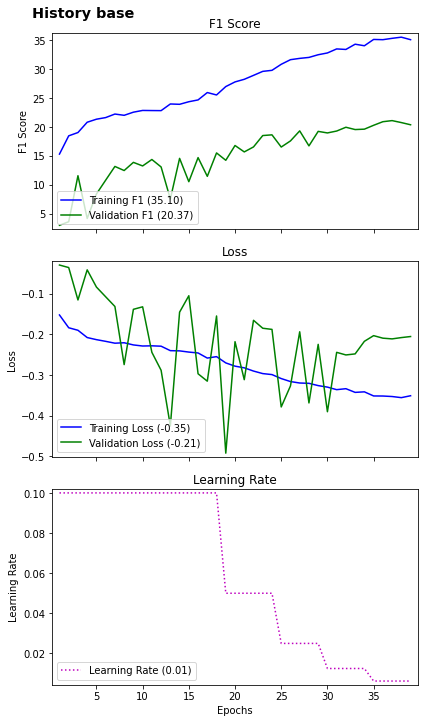

In [4]:
### Baseline Model Training
epochs = 50

# Get timer for baseline training
base_start = time.perf_counter()

# Prepare Baseline Folder
base_folder = os.path.join(test_dir, 'baseline')
if not os.path.exists(base_folder): os.mkdir(base_folder)

# Prepare tensorboard folder
base_tb_dir = os.path.join(base_folder, 'tensorboard')
    
# Prepare Callbacks, including weight output
base_callbacks = kt.SetCallbacks(weights_out=base_folder+'/BaselineWeights.h5', es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path=base_tb_dir)
metrics = [kt.dice_coef,'accuracy', kt.f1_score]
    
if use_gpu:
    with mirror_strategy.scope():
        # Select and Build Model
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

        # Train Model
        baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=base_callbacks)
else:
    # Select and Build Model
    model = kt.Get_Model('UNET')
    model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

    # Train Model
    baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=base_callbacks)

# Save History plot and csv
doc.plot_history(baseline_results, test_dir=base_folder, config_idx='base')

epochs_used = len(baseline_results.history['accuracy'])

    
""" Evaluate Baseline Model Preformance """
print("Baseline Preformance:")
train_rpt = kt.ModelReport(X_train, Y_train, model, 'Training')
val_rpt = kt.ModelReport(X_val, Y_val, model, 'Validation')
test_rpt = kt.ModelReport(X_test, Y_test, model, 'Testing')

print(dt.now().strftime('\n\n%a at %I:%M:%S%p'))


### Part 2: EM Iteration

`Warning`: By proceeding, the EM Iteration will use the model configured above with the parameters already set. Tune the baseline model above as many times as needed before proceeding.

#### Section 1: Configure EM Test with Annotator

In [5]:
seg_class_map_fp = None
preload = False

In [6]:
# Prepare annotator
annotator = Dynamic_Preloading_Annotator(pairs=pairs,                   # Number of pairs to be linearly generated on either side of the source point 
                                         off_dist=off_dist,             # Interval distance that each new pair is generated
                                         interval=interval,             # Inteval at which new candidate groups are generated
                                         min_p=min_probability,         # Minimum valid probability from class map
                                         L=length_weight_value,         # Weight for line distance
                                         weight_buffer=weight_buffer,   # Buffer to apply to candidates when weighting
                                         normalize_full=normalize_full, # Optionally normalize by K^2 instead of K
                                         )

#copy_anno = annotator

# Preload Candidate Data 
if preload:
    if seg_class_map_fp:
        initial_pmap = rio.open(seg_class_map_fp)
    else:
        initial_pmap = kt.Get_Pmap(source_raster=train_raster, pmodel=model, pmap_fp=None)
    print("PRELOADING")
    all_data = annotator.preload_candidates(source_annotation, initial_pmap)
    %store all_data
    #%store annotator
else:
    %store -r all_data
    #%store -r annotator
    
    # Check the annotators for equivalent configuration
    """bad_keys = []
    for key in ['pairs', 'off_dist', 'interval', 'min_p', 'L', 'weight_buffer', 'normalize_full']:
        if (getattr(annotator, key) != getattr(copy_anno, key)):
            bad_keys.append(key)
    if len(bad_keys) > 0:
        raise RuntimeError("Annotators have {} incompatible keys: {}\nCandidates must be regenerated. Configure this in the first block.".format(len(bad_keys),bad_keys))
    
    """
    print("Loaded candidate_data")
    
    
# Prepare performance storage
em_dict = {
    'Name': ['Base'],
    'Test_Data': [test_rpt],
    'Train_Data': [train_rpt],
    'Val_Data': [val_rpt],
    'Line_IoU': [np.round((source_iou*100), 2)],
    'Epochs': [epochs_used],
    'LR': [learning_rate],
    'Training_Time': ['{:.3f} s'.format(time.perf_counter() - base_start)],
    'Update_Time': ['NA'],
}

# Prepare EM iterator index.
EM_iterator = 0

# Prepare storage for top F1 and IoU
top_f1, top_f1_idx = 0, 0
top_iou, top_iou_idx = 0, 0


Loaded candidate_data


In [7]:
buff_dist = 4

#### Run EM Iteration

Beginning Iteration, Target steps: 6

EM Step 00 begun.
Sat at 04:13:26PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 00)
Sat at 04:13:55PM

Created New Annotation. (Step 00)
Sat at 04:16:26PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 00)
Sat at 04:16:30PM

New Learning Rate: 0.100000. (Step 00)
Preparing UNET model...
UNET model built successfully.

Training model...
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
Completed model Training. (Step 00)
Sat at 04:23:32PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 01
 - F1_Score: 41.064
 - Dice_Score: 41.060
 - False_Positives: 30570500.000
 - False_Negatives: 2278500.000
 - Precision: 27.238
 - Recall: 83.396
 - Keras_Precision: 27.238
 - Keras_Recall: 83.396
 - Confusion Matrix: [[9592272  305705]
 [  22785  114438]]

Training Report 01
 - F1_Score: 48.183
 - Dice_Score: 48.183
 - False_Positives: 321177000.000
 - False_Negatives: 670616000.000
 - Precision: 37.272
 - Recall: 68.123
 - Keras_Precision: 52.152
 - Keras_Recall: 34.297
Validation Report 01
 - F1_Score: 36.499
 - Dice_Score: 36.497
 - False_Positives: 20889700.000
 - False_Negatives: 44887300.000
 - Precision: 28.949
 - Recall: 49.377
 - Keras_Precision: 44.521
 - Keras_Recall: 27.191

New Top F1: 41.06

New Top IoU: 19.20

EM Step (00) Complete on Sat at 04:23:58PM
- Annotation IoU:     19.20
	- Source Improvement: +0.94
	- Step Improvement:   +0.94

------ Times ---------------------
- Class Map Generation: 29.058 s
- Annotation Update:    142.104 s
- Model Traini

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 02
 - F1_Score: 52.740
 - Dice_Score: 52.736
 - False_Positives: 17744600.000
 - False_Negatives: 2452700.000
 - Precision: 38.842
 - Recall: 82.126
 - Keras_Precision: 38.842
 - Keras_Recall: 82.126
 - Confusion Matrix: [[9720531  177446]
 [  24527  112696]]

Training Report 02
 - F1_Score: 65.593
 - Dice_Score: 65.592
 - False_Positives: 132312000.000
 - False_Negatives: 714422400.000
 - Precision: 60.405
 - Recall: 71.755
 - Keras_Precision: 69.715
 - Keras_Recall: 29.890
Validation Report 02
 - F1_Score: 47.073
 - Dice_Score: 47.073
 - False_Positives: 9739600.000
 - False_Negatives: 48272600.000
 - Precision: 46.361
 - Recall: 47.807
 - Keras_Precision: 58.722
 - Keras_Recall: 22.302

New Top F1: 52.74

New Top IoU: 25.03

EM Step (01) Complete on Sat at 04:37:52PM
- Annotation IoU:     25.03
	- Source Improvement: +6.77
	- Step Improvement:   +5.83

------ Times ---------------------
- Class Map Generation: 28.814 s
- Annotation Update:    141.604 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 03
 - F1_Score: 52.119
 - Dice_Score: 52.119
 - False_Positives: 15114600.000
 - False_Negatives: 3559000.000
 - Precision: 40.206
 - Recall: 74.064
 - Keras_Precision: 40.206
 - Keras_Recall: 74.064
 - Confusion Matrix: [[9746831  151146]
 [  35590  101633]]

Training Report 03
 - F1_Score: 65.702
 - Dice_Score: 65.701
 - False_Positives: 127129100.000
 - False_Negatives: 711807000.000
 - Precision: 60.629
 - Recall: 71.702
 - Keras_Precision: 70.286
 - Keras_Recall: 29.699
Validation Report 03
 - F1_Score: 50.969
 - Dice_Score: 50.972
 - False_Positives: 8549400.000
 - False_Negatives: 47258800.000
 - Precision: 50.342
 - Recall: 51.611
 - Keras_Precision: 62.405
 - Keras_Recall: 23.094

New Top IoU: 27.19

EM Step (02) Complete on Sat at 04:51:43PM
- Annotation IoU:     27.19
	- Source Improvement: +8.93
	- Step Improvement:   +2.16

------ Times ---------------------
- Class Map Generation: 26.189 s
- Annotation Update:    142.299 s
- Model Training:       624.000 s


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 04
 - F1_Score: 55.937
 - Dice_Score: 55.933
 - False_Positives: 12905800.000
 - False_Negatives: 3383200.000
 - Precision: 44.479
 - Recall: 75.345
 - Keras_Precision: 44.479
 - Keras_Recall: 75.345
 - Confusion Matrix: [[9768919  129058]
 [  33832  103391]]

Training Report 04
 - F1_Score: 70.010
 - Dice_Score: 70.009
 - False_Positives: 92208200.000
 - False_Negatives: 721792100.000
 - Precision: 68.174
 - Recall: 71.948
 - Keras_Precision: 75.824
 - Keras_Recall: 28.605
Validation Report 04
 - F1_Score: 50.453
 - Dice_Score: 50.452
 - False_Positives: 7464600.000
 - False_Negatives: 48330000.000
 - Precision: 52.520
 - Recall: 48.542
 - Keras_Precision: 64.118
 - Keras_Recall: 21.629

New Top F1: 55.94

New Top IoU: 28.87

EM Step (03) Complete on Sat at 05:05:40PM
- Annotation IoU:     28.87
	- Source Improvement: +10.61
	- Step Improvement:   +1.68

------ Times ---------------------
- Class Map Generation: 27.213 s
- Annotation Update:    141.969 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 05
 - F1_Score: 57.565
 - Dice_Score: 57.561
 - False_Positives: 13527900.000
 - False_Negatives: 2709100.000
 - Precision: 44.877
 - Recall: 80.258
 - Keras_Precision: 44.877
 - Keras_Recall: 80.258
 - Confusion Matrix: [[9762698  135279]
 [  27091  110132]]

Training Report 05
 - F1_Score: 71.332
 - Dice_Score: 71.332
 - False_Positives: 92049400.000
 - False_Negatives: 709786700.000
 - Precision: 68.586
 - Recall: 74.307
 - Keras_Precision: 76.146
 - Keras_Recall: 29.278
Validation Report 05
 - F1_Score: 53.717
 - Dice_Score: 53.719
 - False_Positives: 7403700.000
 - False_Negatives: 47607700.000
 - Precision: 55.078
 - Recall: 52.421
 - Keras_Precision: 65.131
 - Keras_Recall: 22.510

New Top F1: 57.57

New Top IoU: 29.96

EM Step (04) Complete on Sat at 05:19:34PM
- Annotation IoU:     29.96
	- Source Improvement: +11.70
	- Step Improvement:   +1.09

------ Times ---------------------
- Class Map Generation: 26.801 s
- Annotation Update:    141.199 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 06
 - F1_Score: 60.437
 - Dice_Score: 60.438
 - False_Positives: 12976400.000
 - False_Negatives: 2160600.000
 - Precision: 47.117
 - Recall: 84.255
 - Keras_Precision: 47.117
 - Keras_Recall: 84.255
 - Confusion Matrix: [[9768213  129764]
 [  21606  115617]]

Training Report 06
 - F1_Score: 73.447
 - Dice_Score: 73.447
 - False_Positives: 75797800.000
 - False_Negatives: 715691300.000
 - Precision: 72.671
 - Recall: 74.239
 - Keras_Precision: 79.227
 - Keras_Recall: 28.771
Validation Report 06
 - F1_Score: 59.427
 - Dice_Score: 59.431
 - False_Positives: 5655700.000
 - False_Negatives: 47313200.000
 - Precision: 62.815
 - Recall: 56.386
 - Keras_Precision: 71.948
 - Keras_Recall: 23.465

New Top F1: 60.44

New Top IoU: 31.49

EM Step (05) Complete on Sat at 05:32:21PM
- Annotation IoU:     31.49
	- Source Improvement: +13.23
	- Step Improvement:   +1.53

------ Times ---------------------
- Class Map Generation: 28.104 s
- Annotation Update:    141.442 s
- Model Trainin

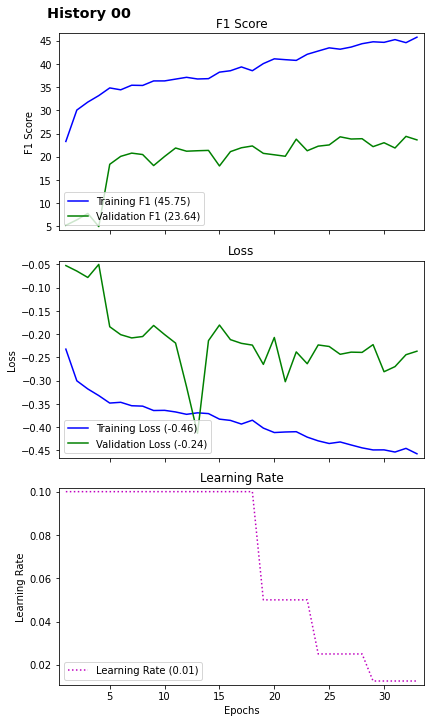

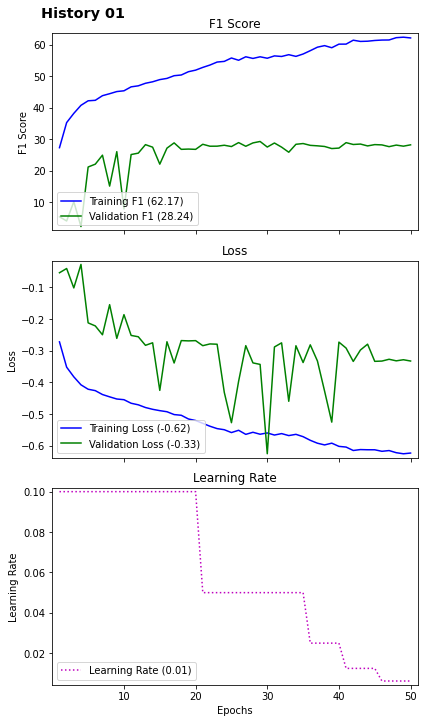

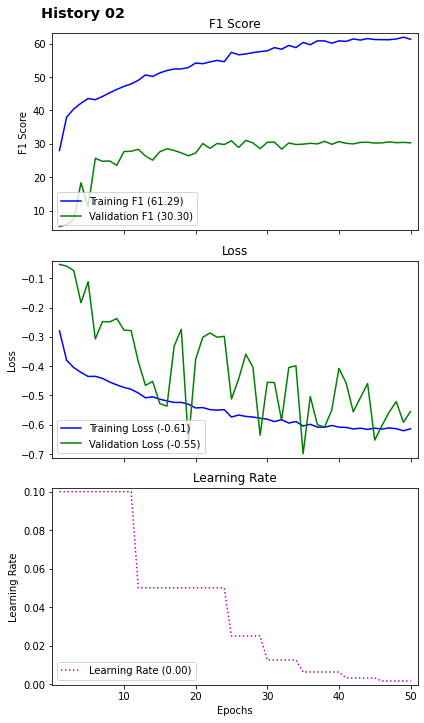

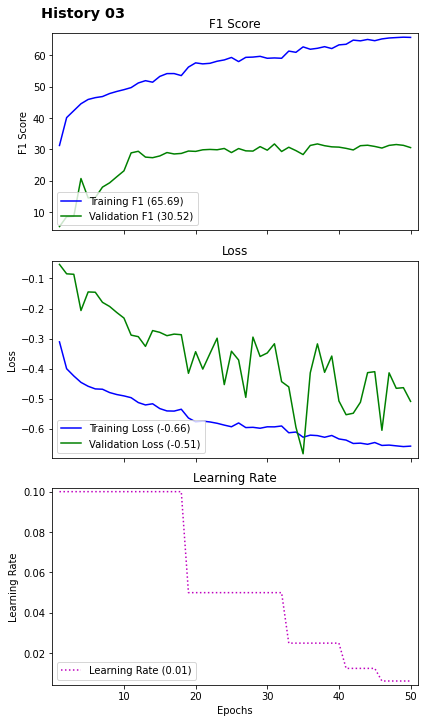

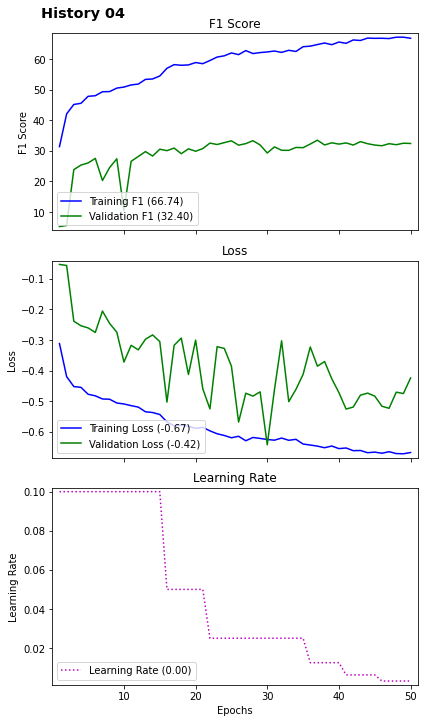

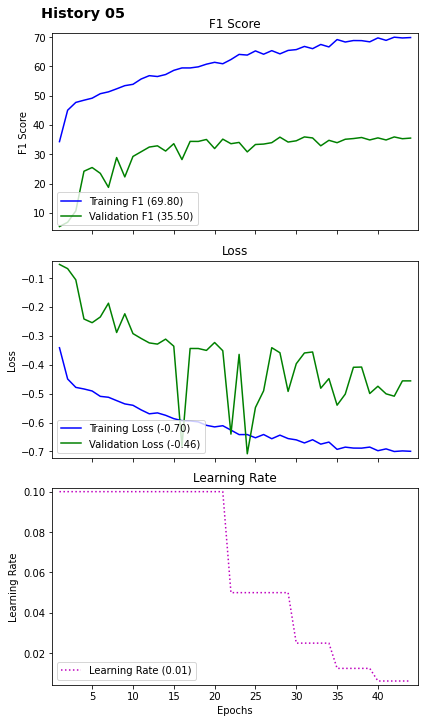

In [8]:
print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


Beginning Iteration, Target steps: 10
Current Step: 6

EM Step 06 begun.
Sat at 05:32:23PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 06)
Sat at 05:32:49PM

Created New Annotation. (Step 06)
Sat at 05:35:21PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 06)
Sat at 05:35:25PM

New Learning Rate: 0.100000. (Step 06)
Preparing UNET model...
UNET model built successfully.

Training model...
Completed model Training. (Step 06)
Sat at 05:43:27PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 07
 - F1_Score: 56.560
 - Dice_Score: 56.559
 - False_Positives: 4161200.000
 - False_Negatives: 6670700.000
 - Precision: 62.889
 - Recall: 51.388
 - Keras_Precision: 62.889
 - Keras_Recall: 51.388
 - Confusion Matrix: [[9856365   41612]
 [  66707   70516]]

Training Report 07
 - F1_Score: 64.576
 - Dice_Score: 64.572
 - False_Positives: 52546100.000
 - False_Negatives: 707654300.000
 - Precision: 65.136
 - Recall: 64.025
 - Keras_Precision: 73.753
 - Keras_Recall: 17.263
Validation Report 07
 - F1_Score: 53.028
 - Dice_Score: 53.023
 - False_Positives: 3517600.000
 - False_Negatives: 45089600.000
 - Precision: 57.573
 - Recall: 49.149
 - Keras_Precision: 68.007
 - Keras_Recall: 14.224

New Top IoU: 32.57

EM Step (06) Complete on Sat at 05:43:53PM
- Annotation IoU:     32.57
	- Source Improvement: +14.32
	- Step Improvement:   +1.09

------ Times ---------------------
- Class Map Generation: 26.120 s
- Annotation Update:    142.813 s
- Model Training:       481.920 s
-

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 08
 - F1_Score: 58.732
 - Dice_Score: 58.731
 - False_Positives: 3401700.000
 - False_Negatives: 6603000.000
 - Precision: 67.668
 - Recall: 51.881
 - Keras_Precision: 67.668
 - Keras_Recall: 51.881
 - Confusion Matrix: [[9863960   34017]
 [  66030   71193]]

Training Report 08
 - F1_Score: 68.715
 - Dice_Score: 68.715
 - False_Positives: 33615100.000
 - False_Negatives: 711584900.000
 - Precision: 74.331
 - Recall: 63.888
 - Keras_Precision: 80.569
 - Keras_Recall: 16.379
Validation Report 08
 - F1_Score: 58.252
 - Dice_Score: 58.249
 - False_Positives: 2242500.000
 - False_Negatives: 45210900.000
 - Precision: 68.479
 - Recall: 50.682
 - Keras_Precision: 76.341
 - Keras_Recall: 13.797

New Top IoU: 33.72

EM Step (07) Complete on Sat at 05:55:57PM
- Annotation IoU:     33.72
	- Source Improvement: +15.46
	- Step Improvement:   +1.15

------ Times ---------------------
- Class Map Generation: 25.988 s
- Annotation Update:    142.328 s
- Model Training:       516.377 s
-

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 09
 - F1_Score: 61.205
 - Dice_Score: 61.208
 - False_Positives: 3623500.000
 - False_Negatives: 6073300.000
 - Precision: 67.855
 - Recall: 55.741
 - Keras_Precision: 67.855
 - Keras_Recall: 55.741
 - Confusion Matrix: [[9861742   36235]
 [  60733   76490]]

Training Report 09
 - F1_Score: 70.948
 - Dice_Score: 70.949
 - False_Positives: 29739800.000
 - False_Negatives: 709533000.000
 - Precision: 77.123
 - Recall: 65.688
 - Keras_Precision: 82.669
 - Keras_Recall: 16.662
Validation Report 09
 - F1_Score: 59.318
 - Dice_Score: 59.316
 - False_Positives: 2310500.000
 - False_Negatives: 45078200.000
 - Precision: 68.733
 - Recall: 52.171
 - Keras_Precision: 76.380
 - Keras_Recall: 14.218

New Top F1: 61.20

EM Step (08) Complete on Sat at 06:09:53PM
- Annotation IoU:     33.41
	- Source Improvement: +15.15
	- Step Improvement:   -0.31

------ Times ---------------------
- Class Map Generation: 28.797 s
- Annotation Update:    141.486 s
- Model Training:       626.503 s
- 

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 10
 - F1_Score: 58.545
 - Dice_Score: 58.537
 - False_Positives: 3251700.000
 - False_Negatives: 6697200.000
 - Precision: 68.359
 - Recall: 51.195
 - Keras_Precision: 68.359
 - Keras_Recall: 51.195
 - Confusion Matrix: [[9865460   32517]
 [  66972   70251]]

Training Report 10
 - F1_Score: 72.024
 - Dice_Score: 72.023
 - False_Positives: 26843100.000
 - False_Negatives: 706615300.000
 - Precision: 78.962
 - Recall: 66.207
 - Keras_Precision: 83.983
 - Keras_Recall: 16.610
Validation Report 10
 - F1_Score: 61.803
 - Dice_Score: 61.801
 - False_Positives: 2064500.000
 - False_Negatives: 44568200.000
 - Precision: 71.273
 - Recall: 54.554
 - Keras_Precision: 78.828
 - Keras_Recall: 14.710

EM Step (09) Complete on Sat at 06:23:41PM
- Annotation IoU:     33.57
	- Source Improvement: +15.31
	- Step Improvement:   +0.15

------ Times ---------------------
- Class Map Generation: 27.206 s
- Annotation Update:    141.508 s
- Model Training:       618.183 s
- Model Evaluation:  

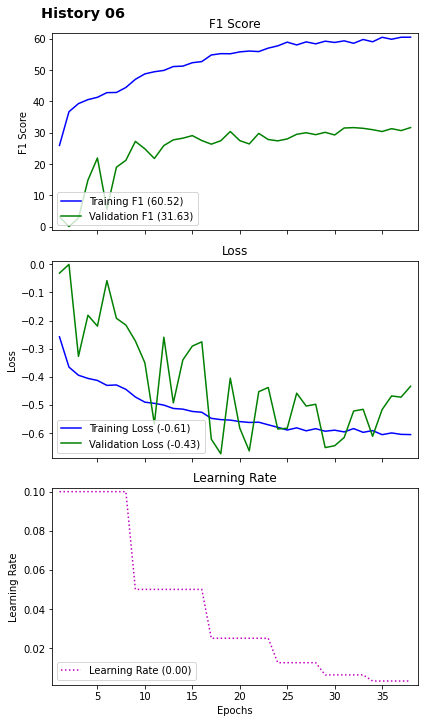

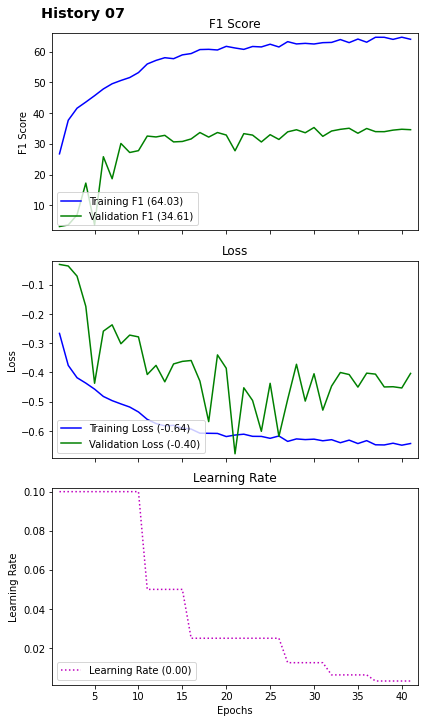

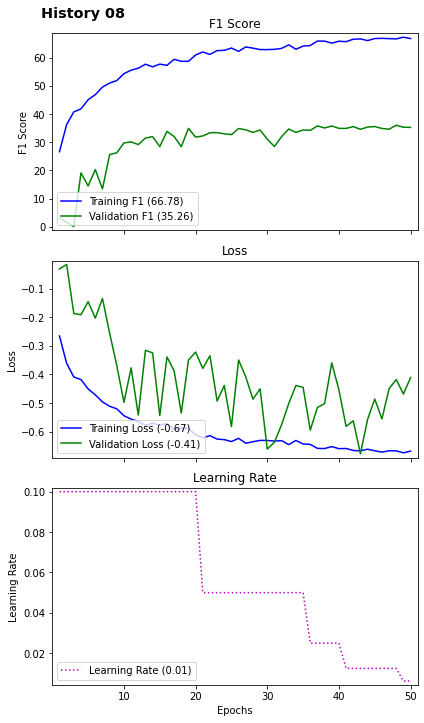

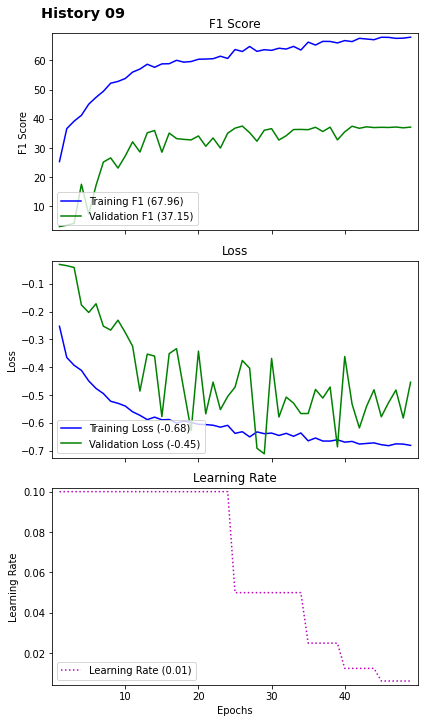

In [9]:
em_target = 10
buff_dist = 2

print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


Beginning Iteration, Target steps: 14
Current Step: 10

EM Step 10 begun.
Sat at 06:23:42PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 10)
Sat at 06:24:09PM

Created New Annotation. (Step 10)
Sat at 06:26:39PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 10)
Sat at 06:26:44PM

New Learning Rate: 0.100000. (Step 10)
Preparing UNET model...
UNET model built successfully.

Training model...
Completed model Training. (Step 10)
Sat at 06:37:10PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 11
 - F1_Score: 55.792
 - Dice_Score: 55.792
 - False_Positives: 3784700.000
 - False_Negatives: 6949100.000
 - Precision: 64.153
 - Recall: 49.359
 - Keras_Precision: 64.153
 - Keras_Recall: 49.359
 - Confusion Matrix: [[9860130   37847]
 [  69491   67732]]

Training Report 11
 - F1_Score: 71.584
 - Dice_Score: 71.582
 - False_Positives: 31736600.000
 - False_Negatives: 703353600.000
 - Precision: 76.367
 - Recall: 67.365
 - Keras_Precision: 82.062
 - Keras_Recall: 17.110
Validation Report 11
 - F1_Score: 63.349
 - Dice_Score: 63.356
 - False_Positives: 2026000.000
 - False_Negatives: 44396600.000
 - Precision: 72.256
 - Recall: 56.397
 - Keras_Precision: 79.542
 - Keras_Recall: 15.069

EM Step (10) Complete on Sat at 06:37:38PM
- Annotation IoU:     33.39
	- Source Improvement: +15.14
	- Step Improvement:   -0.17

------ Times ---------------------
- Class Map Generation: 26.173 s
- Annotation Update:    141.670 s
- Model Training:       625.915 s
- Model Evaluation:  

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 12
 - F1_Score: 55.216
 - Dice_Score: 55.222
 - False_Positives: 3649700.000
 - False_Negatives: 7097100.000
 - Precision: 64.479
 - Recall: 48.281
 - Keras_Precision: 64.479
 - Keras_Recall: 48.281
 - Confusion Matrix: [[9861480   36497]
 [  70971   66252]]

Training Report 12
 - F1_Score: 71.430
 - Dice_Score: 71.429
 - False_Positives: 30502700.000
 - False_Negatives: 705529200.000
 - Precision: 76.965
 - Recall: 66.637
 - Keras_Precision: 82.481
 - Keras_Recall: 16.913
Validation Report 12
 - F1_Score: 57.554
 - Dice_Score: 57.559
 - False_Positives: 2331400.000
 - False_Negatives: 45250700.000
 - Precision: 67.442
 - Recall: 50.195
 - Keras_Precision: 75.465
 - Keras_Recall: 13.679

EM Step (11) Complete on Sat at 06:51:32PM
- Annotation IoU:     32.88
	- Source Improvement: +14.62
	- Step Improvement:   -0.51

------ Times ---------------------
- Class Map Generation: 26.422 s
- Annotation Update:    142.372 s
- Model Training:       624.892 s
- Model Evaluation:  

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 13
 - F1_Score: 58.081
 - Dice_Score: 58.078
 - False_Positives: 4040900.000
 - False_Negatives: 6452600.000
 - Precision: 64.273
 - Recall: 52.977
 - Keras_Precision: 64.273
 - Keras_Recall: 52.977
 - Confusion Matrix: [[9857568   40409]
 [  64526   72697]]

Training Report 13
 - F1_Score: 71.416
 - Dice_Score: 71.415
 - False_Positives: 33902500.000
 - False_Negatives: 699016800.000
 - Precision: 75.216
 - Recall: 67.981
 - Keras_Precision: 81.169
 - Keras_Recall: 17.290
Validation Report 13
 - F1_Score: 59.117
 - Dice_Score: 59.113
 - False_Positives: 2519400.000
 - False_Negatives: 44626100.000
 - Precision: 66.695
 - Recall: 53.086
 - Keras_Precision: 75.059
 - Keras_Recall: 14.523

EM Step (12) Complete on Sat at 07:03:28PM
- Annotation IoU:     32.84
	- Source Improvement: +14.58
	- Step Improvement:   -0.05

------ Times ---------------------
- Class Map Generation: 26.864 s
- Annotation Update:    142.511 s
- Model Training:       506.965 s
- Model Evaluation:  

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 14
 - F1_Score: 57.355
 - Dice_Score: 57.357
 - False_Positives: 4014900.000
 - False_Negatives: 6590500.000
 - Precision: 63.981
 - Recall: 51.972
 - Keras_Precision: 63.981
 - Keras_Recall: 51.972
 - Confusion Matrix: [[9857828   40149]
 [  65905   71318]]

Training Report 14
 - F1_Score: 70.489
 - Dice_Score: 70.489
 - False_Positives: 32157700.000
 - False_Negatives: 704609300.000
 - Precision: 75.755
 - Recall: 65.908
 - Keras_Precision: 81.524
 - Keras_Recall: 16.762
Validation Report 14
 - F1_Score: 58.158
 - Dice_Score: 58.161
 - False_Positives: 2263100.000
 - False_Negatives: 45078000.000
 - Precision: 68.214
 - Recall: 50.686
 - Keras_Precision: 76.188
 - Keras_Recall: 13.840

EM Step (13) Complete on Sat at 07:15:59PM
- Annotation IoU:     32.29
	- Source Improvement: +14.04
	- Step Improvement:   -0.54

------ Times ---------------------
- Class Map Generation: 36.235 s
- Annotation Update:    142.054 s
- Model Training:       532.192 s
- Model Evaluation:  

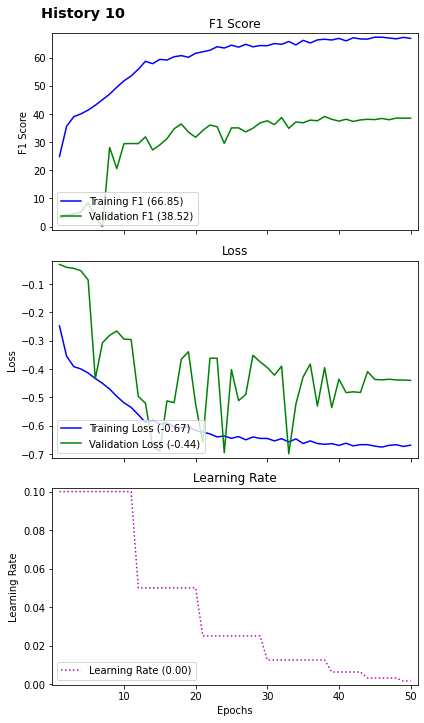

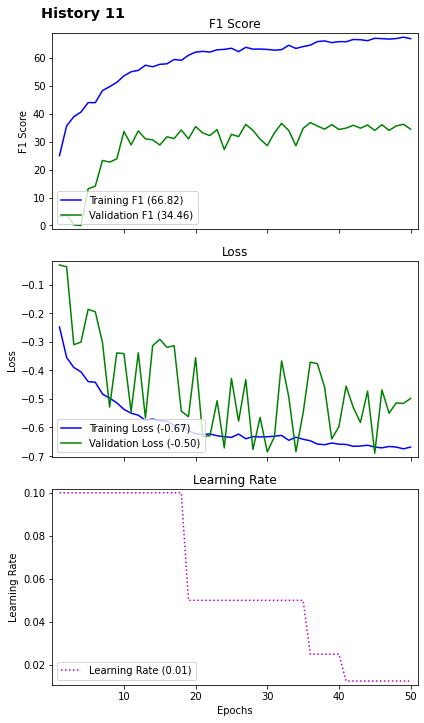

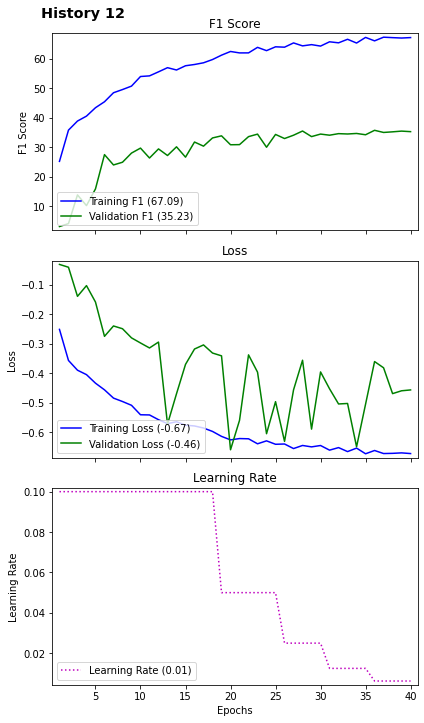

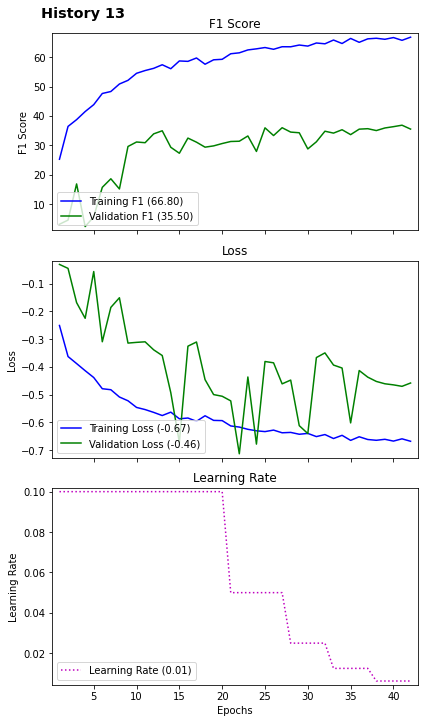

In [10]:
buff_dist = 2

em_target = 14

print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1

### Create Plots

/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


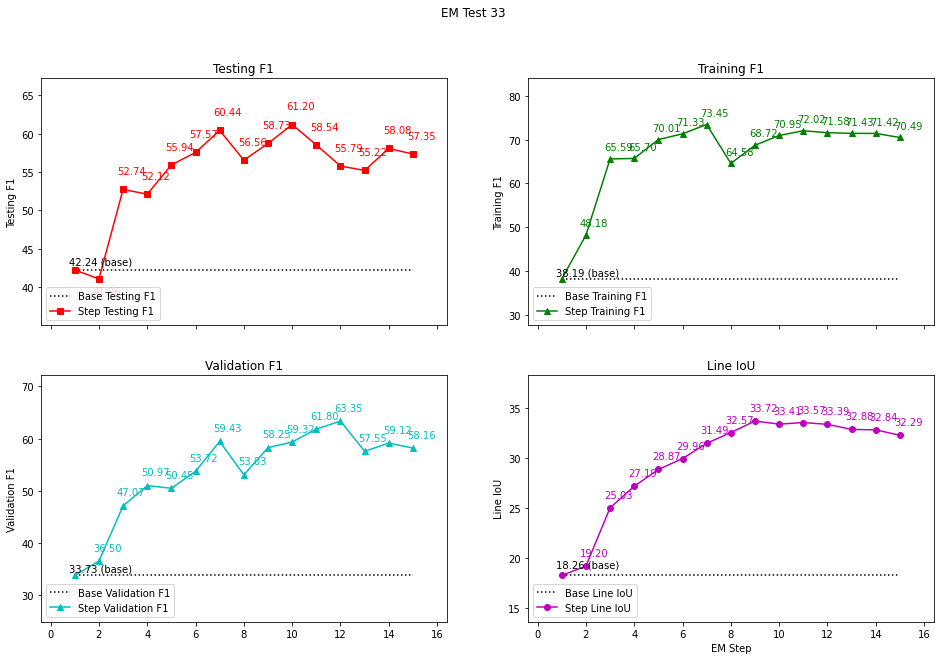

In [11]:
# Clean data for easy indexing

## Converts each of the report lists into a dict of lists for each value
model_dict = {'Test_Data': {}, 'Train_Data': {}, 'Val_Data': {}}
for em_key in model_dict.keys():
    for report in em_dict[em_key]:
        for rpt_key, rpt_value in [(key, item) for key, item in report.items()]:
            if rpt_key not in model_dict[em_key].keys():
                model_dict[em_key].update({rpt_key: np.array([rpt_value])})
            else:
                model_dict[em_key][rpt_key] = np.append(model_dict[em_key][rpt_key], report[rpt_key])


# Create Figure for Plots
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(16,10))

## Plot Testing F1
doc.plot_axis(ax=axs[0,0], 
              data=model_dict['Test_Data']['F1_Score']*100, 
              name='Testing F1', 
              color_char='r', 
              symbol_char='s', 
              y_off=2,
              label_delta=False)

## Plot Training F1
doc.plot_axis(ax=axs[0,1], 
              data=model_dict['Train_Data']['F1_Score']*100, 
              name='Training F1', 
              color_char='g', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Validation F1
doc.plot_axis(ax=axs[1,0], 
              data=model_dict['Val_Data']['F1_Score']*100, 
              name='Validation F1', 
              color_char='c', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Annotation IoU
doc.plot_axis(ax=axs[1,1], 
              data=em_dict['Line_IoU'], 
              name='Line IoU', 
              color_char='m', 
              x_label='EM Step',
              label_delta=False)
    
## Title and show, and save figure
fig.suptitle("EM Test {:02}".format(test_idx))
fig_path = os.path.join(test_dir, 'test_{:02}_plot.png'.format(test_idx))
fig.savefig(fig_path)
fig.show()


### Save to Markdown

Saves:
- Annotator Config
- Model Config
- EM preformance table
- Model preformance table

In [ ]:
### Write test data to markdown
markdown_fp = os.path.join(test_dir, 'em_test_info_{:02}.md'.format(test_idx))
md = open(markdown_fp, 'w+')

# Header / Notes
md.write("# EM Test {:02}\n\n".format(test_idx))

if (len(test_notes) > 0):
    md.write("### Notes: \n")
    md.write(test_notes)

md.write(dt.now().strftime('\n%a at %I:%M:%S%p'))
    
md.write("\n\n---\n\n")

# prepare peak values
top_f1 = np.round((top_f1*100), 3)
source_f1 = np.round((em_dict['Test_Data'][0]['F1_Score']*100), 3)
source_iou = np.round(source_iou*100, 2)

# Note at top the peak values 
md.write("### Top Values:\n\n")
md.write(" - Testing F1 Score: **{:.2f}** (`{:+.2f}`) - Step {:02}\n".format(top_f1, (top_f1-source_f1), top_f1_idx))
md.write(" - Annotation IoU: **{:.2f}** (`{:+.2f}`) - Step {:02}\n\n\n".format(top_iou, (top_iou-source_iou), top_iou_idx))



# Test Configuration Section
md.write("## **Test Config**\n\n")

md.write("### Seeds:\n")
md.write("`Python`: {}, `Numpy`: {}, `Tensorflow`: {}\n\n".format(py_seed, np_seed, tf_seed))

md.write("### Annotator:\n")
for key, item in annotator.__dict__.items():
    
    # Skip gross keys
    if key in ['verbosity', 'crop_window', 'class_map', 'kwargs_key', 'crs']:
        continue
    
    # Write key and item
    md.write("- `{}`: {}\n".format(key, item))
        
md.write("\n\n")

md.write("### Model:\n")
md.write("- **Training**:\n")
md.write("  - `Batch Size`: {}\n".format(batch_size))
md.write("  - `Learning Rate`: {}\n".format(learning_rate))
md.write("  - `Epochs`: {}\n".format(epochs))
md.write("- **Callbacks**:\n")
md.write("  - `ES Patience`: {}\n".format(es_patience))
md.write("  - `RLOP Factor`: {}\n".format(rlop_factor))
md.write("  - `Adam Epsilon`: {}\n".format(adam_epsilon))
md.write("  - `Adam Decay`: {}\n".format(adam_decay))

md.write("\n\n")

md.write("### Other:\n")
md.write("- EM Steps: {}\n".format(em_target))
md.write("- ClassMap: '{}'\n".format(seg_class_map_fp))


md.write("\n---\n\n")


# Results Section

md.write("## **Results**:\n\n")

md.write("### EM Iteration:\n\n")

md.write("Step | Anno IoU | F1 | Epochs | LR | Train | Update\n")
md.write("---- | -------- | -- | ------ | -- | ----- | ------\n")
for idx in range(em_target):
    if idx == 0:
        md.write("{} | {} | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))
    else:
        md.write("{} | {} (`{:+.2f}`) | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], (em_dict['Line_IoU'][idx] - em_dict['Line_IoU'][0]), em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))

md.write("\n\n</br>\n\n")
    
md.write("### Model Performance:\n\n")
md.write("Step | Test F1 | Test (FP, FN) | Train F1 | Train (FP, FN) | Val F1 | Val (FP, FN) | LR \n")
md.write("---- | ------- | ------------- | -------- | -------------- | ------ | ------------ | -- \n")
for idx in range(em_target):
    # Create a string to hold this row's data
    row_string = "{} | ".format(em_dict['Name'][idx])
    
    # Iterate over F1 types
    for key in ['Test_Data', 'Train_Data', 'Val_Data']:
        
        if idx == 0:
            row_string += "{:.2f} | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
        else:
            row_string += "{:.2f} (`{:+.2f}`) | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, (em_dict[key][idx]['F1_Score']*100 - em_dict[key][0]['F1_Score']*100), em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
      
    # After all sets have been added, append learning rate and newline
    row_string += "{}\n".format(em_dict['LR'][idx])
    md.write(row_string)


# Close Markdown
md.close()

print("Config and results written to markdown.")
print("Location:", markdown_fp)